In [1]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

data = pd.read_csv(file_path, parse_dates=['Time'])

data = data.drop(columns=["Unnamed: 0"], errors='ignore')

In [3]:
data.shape

(2165, 30)

In [4]:
data.columns

Index(['Time', 'Buy', 'Sell', 'Price', 'BidPrice', 'AskPrice', 'Volume',
       'VPIN', 'CDF', 'Roll', 'RollImpact', 'KyleLambda', 'Returns',
       'AmihudLambda', 'BidAskSpread', 'SpreadChangeSign',
       'RealizedVolatility', 'RealizedVolatilitySign', 'ReturnsSign',
       'Skewness', 'Kurtosis', 'JB_rolling', 'JB_ChangeSign', 'AR',
       'AR_ChangeSign', 'SkewnessSign', 'KurtosisSign', 'MA_20', 'MA_50',
       'MASign'],
      dtype='object')

In [5]:
data.head()

,Time,Buy,Sell,Price,BidPrice,AskPrice,Volume,VPIN,CDF,Roll,...,Kurtosis,JB_rolling,JB_ChangeSign,AR,AR_ChangeSign,SkewnessSign,KurtosisSign,MA_20,MA_50,MASign
0,2025-09-05 14:12:14+00:00,117.364530,223.635470,112489.040038,112462.227664,112503.111248,341.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,2025-09-05 14:15:59+00:00,188.781099,152.218901,112234.888011,112250.620861,112215.376211,341.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,2025-09-05 14:18:53+00:00,115.845049,225.154951,111781.276851,111829.440780,111756.495905,341.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,2025-09-05 14:23:15+00:00,171.826973,169.173027,111382.112244,111381.182735,111383.056335,341.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,2025-09-05 14:26:34+00:00,93.045830,247.954170,111153.350199,111182.321621,111142.478552,341.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


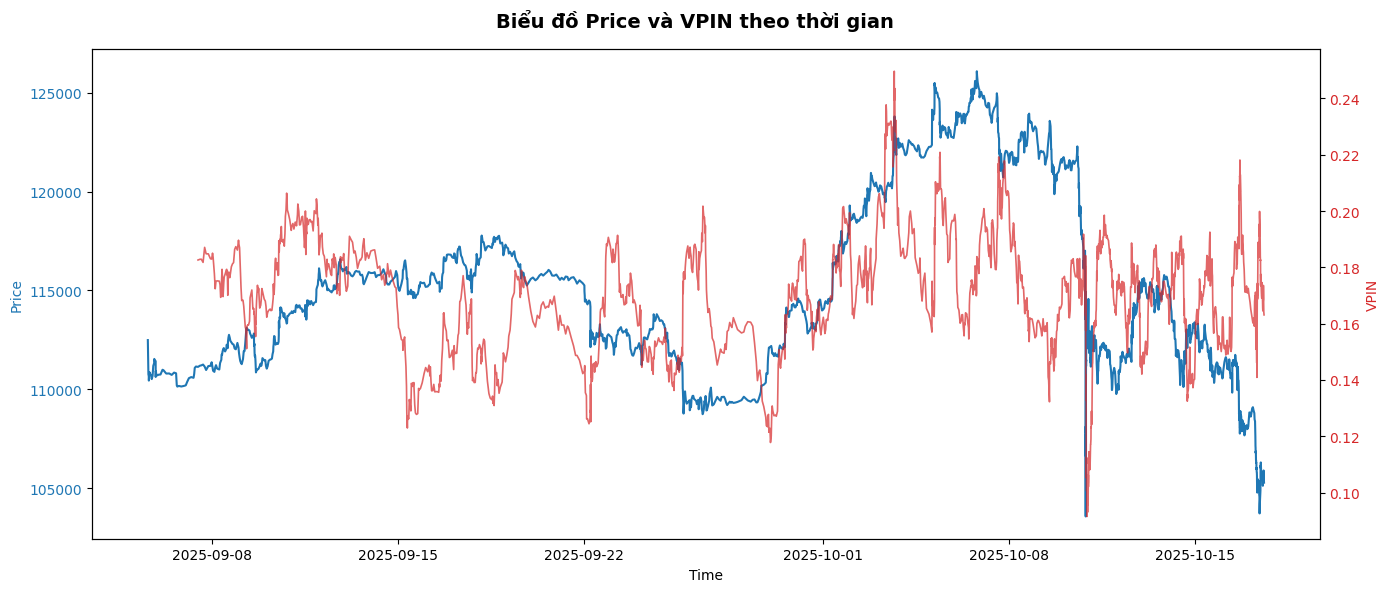

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Tạo bản sao an toàn
df = data.copy()

# Đảm bảo cột 'Time' ở dạng datetime (nếu chưa)
df['Time'] = pd.to_datetime(df['Time'])

# Tạo figure và hai trục y
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Trục Y1: Price ---
color_price = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color=color_price)
ax1.plot(df['Time'], df['Price'], color=color_price, label='Price', linewidth=1.5)
ax1.tick_params(axis='y', labelcolor=color_price)

# --- Trục Y2: VPIN ---
ax2 = ax1.twinx()
color_vpin = 'tab:red'
ax2.set_ylabel('VPIN', color=color_vpin)
ax2.plot(df['Time'], df['VPIN'], color=color_vpin, label='VPIN', linewidth=1.2, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color_vpin)

# --- Tiêu đề & hiển thị ---
fig.suptitle('Biểu đồ Price và VPIN theo thời gian', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()


/var/folders/s9/x79qrc253njd_hw1lrw0xqnw0000gn/T/ipykernel_3189/3617101165.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


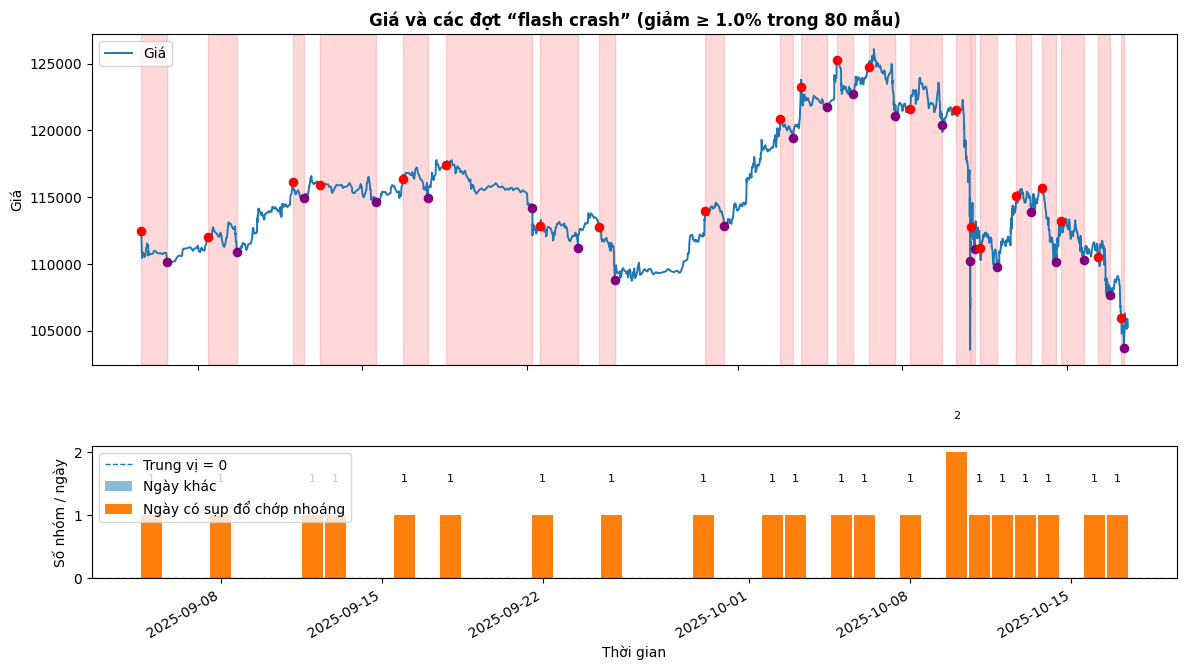

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# ================== THAM SỐ CÓ THỂ CHỈNH ==================
# THAM SỐ CÓ THỂ CHỈNH
DROP_PCT = 0.01       # giảm ngưỡng từ 2% → 1% để nhạy hơn
WINDOW_N = 80         # tăng cửa sổ xét từ 60 → 80 mẫu
COOLDOWN = 30         # giảm thời gian "nghỉ" để nhận nhiều đợt gần nhau hơn

ANNOTATE_TOP_DAYS = True  # Ghi số lượng sự kiện trên cột (ở panel dưới)
# ==========================================================

# Bản sao an toàn để không đụng vào data gốc
df = data.copy()

# Chuẩn hóa thời gian
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)

# ------------ TÍNH MIN TƯƠNG LAI & TỶ LỆ GIẢM TRONG CỬA SỔ ------------
# future_min: với mỗi i, là min(Price[i : i+WINDOW_N])
future_min = df['Price'][::-1].rolling(window=WINDOW_N, min_periods=1).min()[::-1]
drop_pct = (future_min - df['Price']) / df['Price']  # sẽ âm khi giảm

# ------------ PHÁT HIỆN SỰ KIỆN FLASH CRASH ------------
events = []  # mỗi event: dict(start_idx, trough_idx)
i = 0
n = len(df)
prices = df['Price'].values

while i < n:
    if drop_pct.iat[i] <= -DROP_PCT:
        # Xác định khoảng xét tương lai
        end_i = min(i + WINDOW_N, n)
        # Chọn đáy (trough) trong cửa sổ
        window_slice = prices[i:end_i]
        trough_off = np.argmin(window_slice)  # offset trong cửa sổ
        trough_i = i + trough_off
        events.append({"start_idx": i, "trough_idx": trough_i})
        # Bỏ qua cooldown để tránh đánh dấu dày đặc cùng đợt
        i = max(trough_i + COOLDOWN, i + 1)
    else:
        i += 1

# Chuyển sự kiện sang DataFrame tiện xử lý/đếm theo ngày
ev_df = pd.DataFrame(events)
if not ev_df.empty:
    ev_df['start_time'] = df.loc[ev_df['start_idx'], 'Time'].values
    ev_df['trough_time'] = df.loc[ev_df['trough_idx'], 'Time'].values
    ev_df['start_price'] = df.loc[ev_df['start_idx'], 'Price'].values
    ev_df['trough_price'] = df.loc[ev_df['trough_idx'], 'Price'].values
    ev_df['drop_pct'] = (ev_df['trough_price'] - ev_df['start_price']) / ev_df['start_price']
else:
    # Nếu không có sự kiện
    ev_df = pd.DataFrame(columns=['start_idx', 'trough_idx', 'start_time', 'trough_time',
                                  'start_price', 'trough_price', 'drop_pct'])

# ------------ CHUẨN BỊ DỮ LIỆU ĐẾM SỰ KIỆN THEO NGÀY ------------
df_day = df[['Time']].copy()
df_day['date'] = df_day['Time'].dt.date

if not ev_df.empty:
    ev_counts = ev_df.groupby(ev_df['start_time'].dt.date).size().rename('count')
else:
    ev_counts = pd.Series(dtype=int)

day_counts = pd.DataFrame({'date': sorted(df_day['date'].unique())})
day_counts = day_counts.merge(ev_counts, left_on='date', right_index=True, how='left').fillna(0)
day_counts['count'] = day_counts['count'].astype(int)
median_cnt = int(day_counts['count'].median()) if len(day_counts) else 0

# ------------ VẼ HÌNH 2-PANEL ------------
plt.rcParams.update({'axes.grid': False})
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[2.5, 1.0], hspace=0.35)

# ===== Panel 1: Giá + đánh dấu flash crash =====
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df['Time'], df['Price'], label='Giá', linewidth=1.4)

# Tô nền vùng flash crash và đánh dấu điểm bắt đầu/đáy
if not ev_df.empty:
    for _, row in ev_df.iterrows():
        t0 = row['start_time']
        t1 = row['trough_time']
        # vùng đỏ nhạt: từ start tới trough
        ax1.axvspan(t0, t1, alpha=0.15, color='red')
        # đánh dấu điểm start (đỏ) và trough (tím)
        ax1.scatter(t0, row['start_price'], color='red', s=35, zorder=3, label='_nolegend_')
        ax1.scatter(t1, row['trough_price'], color='purple', s=35, zorder=3, label='_nolegend_')

# Trang trí
ax1.set_title('Giá và các đợt “flash crash” (giảm ≥ {:.1f}% trong {} mẫu)'.format(DROP_PCT*100, WINDOW_N),
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Giá')
ax1.legend(loc='upper left')

# ===== Panel 2: Số sự kiện theo ngày =====
ax2 = fig.add_subplot(gs[1, 0], sharex=None)

# Thanh màu cam cho ngày có sự kiện, xám cho ngày khác
dates = pd.to_datetime(day_counts['date'])
counts = day_counts['count'].values
has_event = counts > 0

ax2.bar(dates[~has_event], counts[~has_event], width=0.9, alpha=0.5, label='Ngày khác')
ax2.bar(dates[has_event], counts[has_event], width=0.9, label='Ngày có sụp đổ chớp nhoáng')

# Đường median
ax2.axhline(median_cnt, linestyle='--', linewidth=1, label=f'Trung vị = {median_cnt}')

# Ghi số lên cột (tuỳ chọn)
if ANNOTATE_TOP_DAYS and len(day_counts):
    for x, y in zip(dates[has_event], counts[has_event]):
        if y > 0:
            ax2.text(x, y + 0.5, f'{y}', ha='center', va='bottom', fontsize=8)

ax2.set_ylabel('Số nhóm / ngày')
ax2.set_xlabel('Thời gian')
ax2.legend(loc='upper left')

# Set x tick format nghiêng cho dễ đọc
fig.autofmt_xdate(rotation=30)
plt.tight_layout()
plt.show()

# ========== GỢI Ý ==========
# - Nếu dữ liệu theo phút/giây đều, bạn có thể đổi WINDOW_N theo thời gian thực (ví dụ 15 phút)
#   bằng cách quy ước WINDOWS_N = 15 * (số mẫu/phút).
# - Đổi ngưỡng: DROP_PCT = 0.03 (3%), 0.05 (5%)...
# - Nếu mẫu quá dày, tăng COOLDOWN để gộp các đợt gần nhau thành 1 sự kiện.


Số flash (1/ngày bận): 10 — days=['2025-10-10', '2025-10-11', '2025-10-12', '2025-10-14', '2025-10-16', '2025-10-17', '2025-10-03', '2025-10-15', '2025-10-13', '2025-10-05']


/var/folders/s9/x79qrc253njd_hw1lrw0xqnw0000gn/T/ipykernel_3189/3172043658.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


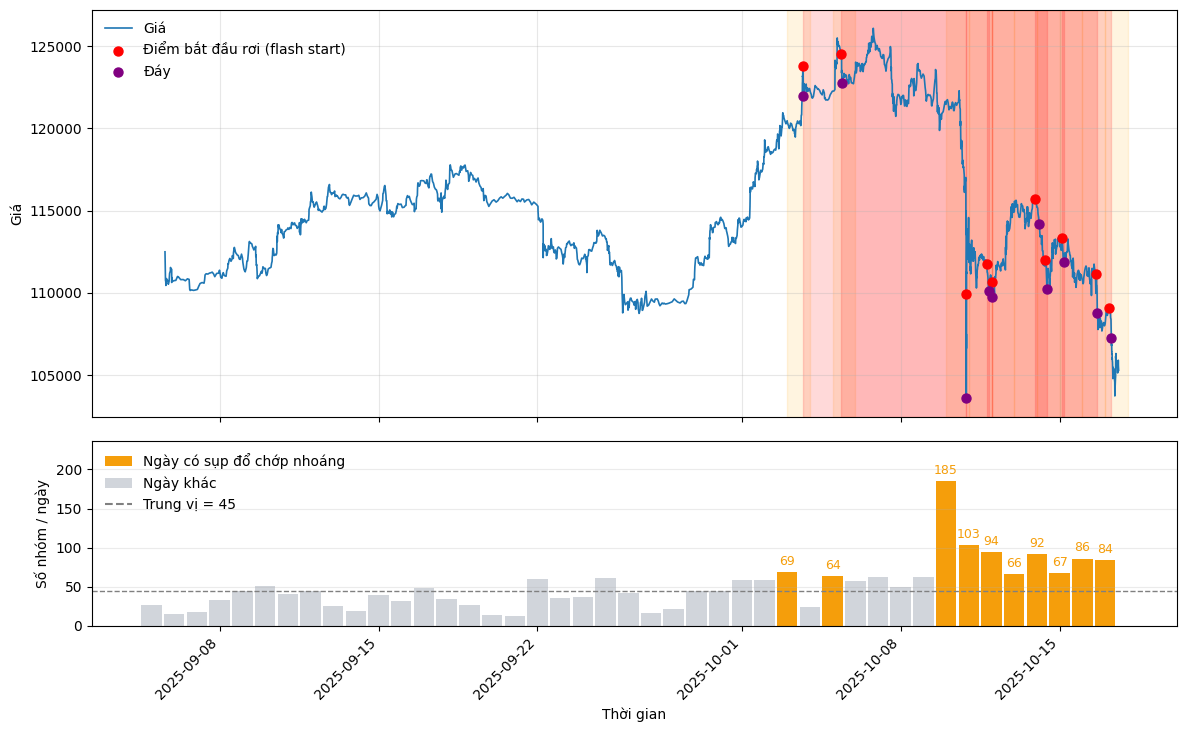

            buckets_per_day  window_hours_median  window_hours_min  window_hours_max
day                                                                                 
2025-09-05               26                  NaN               NaN               NaN
2025-09-06               15                  NaN               NaN               NaN
2025-09-07               17                51.06             45.32             56.99
2025-09-08               33                58.97             46.64             61.80
2025-09-09               45                30.84             26.67             46.28
2025-09-10               51                23.82             21.84             28.65
2025-09-11               40                24.98             22.23             30.86
2025-09-12               44                27.22             25.88             29.99
2025-09-13               25                32.40             25.97             36.86
2025-09-14               19                44.36             38.4

In [8]:
# ===== INPUT =====
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

N = 50                 # độ dài cửa sổ VPIN (để tính "bucket clock")
m_fwd = 7              # số bucket nhìn tới để đo drawdown (start -> trough)
min_abs_drop = -0.008  # ngưỡng rơi tối thiểu để coi là flash (0.8%)
tz = df.index.tz

# ===== Buckets/day & "bucket clock" =====
per_day = (
    df.assign(day=(df.index.tz_convert(tz).date if tz else df.index.date))
      .groupby('day').size().rename('buckets_per_day')
)

idx = df.index
earlier_idx = idx.to_series().shift(N-1)
df['vp_window_hours'] = (idx.to_series() - earlier_idx).dt.total_seconds()/3600.0

# ===== Drawdown tương lai (dd_m) & trough =====
def forward_drawdown(s_price: pd.Series, m: int):
    fut = pd.concat([s_price.shift(-k) for k in range(1, m+1)], axis=1)
    fwd_min = fut.min(axis=1)
    dd_m = (fwd_min / s_price) - 1
    return dd_m, fut

dd_m, fut_matrix = forward_drawdown(df['Price'], m_fwd)

# ===== CHỌN 2 NGÀY "BẬN" NHẤT rồi lấy 1 flash sâu nhất/ngày
busy_days = per_day.sort_values(ascending=False).head(10).index  # kiểu date

starts, troughs = [], []
for d in busy_days:
    mask_day = (dd_m.index.tz_convert(tz).date == d) if tz else (dd_m.index.date == d)
    dd_day = dd_m[mask_day]
    if dd_day.empty:
        continue
    t_star = dd_day.idxmin()
    if np.isnan(dd_m.loc[t_star]) or dd_m.loc[t_star] > min_abs_drop:
        continue
    row = fut_matrix.loc[t_star].values
    j = int(np.nanargmin(row))  # 0..m_fwd-1
    trough_pos = df.index.get_loc(t_star) + (j+1)
    trough_pos = max(0, min(trough_pos, len(df.index)-1))
    t_trough = df.index[trough_pos]
    starts.append(t_star); troughs.append(t_trough)

starts = pd.DatetimeIndex(sorted(starts))
troughs = pd.DatetimeIndex([t for _, t in sorted(zip(starts, troughs))])
flash_days = {(t.tz_convert(tz).date if tz else t.date()) for t in starts}  # set ngày có flash

print(f"Số flash (1/ngày bận): {len(starts)} — days={list(map(str, busy_days))}")

# ===== VẼ =====
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2, 1, height_ratios=[2.2, 1], hspace=0.08)
ax_p = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[1, 0], sharex=ax_p)

# --- Panel trên: GIÁ + flash ---
ax_p.plot(df.index, df['Price'], label='Giá', linewidth=1.2)

# Tô nền 2 ngày bận
for d in busy_days:
    d0 = pd.Timestamp(d).tz_localize(tz) if tz else pd.Timestamp(d)
    d1 = d0 + pd.Timedelta(days=1)
    ax_p.axvspan(d0, d1, color='orange', alpha=0.12, zorder=0)

# Markers
if len(starts):
    ax_p.scatter(starts, df.loc[starts,'Price'], s=42, color='red',
                 label='Điểm bắt đầu rơi (flash start)', zorder=3)
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs,'Price'], s=42, color='purple',
                 label='Đáy', zorder=3)
for st, tr in zip(starts, troughs):
    if pd.notna(tr) and tr >= st:
        ax_p.axvspan(st, tr, alpha=0.15, color='red')

ax_p.set_ylabel('Giá')
ax_p.grid(alpha=.3)
ax_p.legend(loc='upper left', frameon=False)

# --- Panel dưới: SỐ BUCKET MỖI NGÀY (highlight ngày có flash) ---
# chuẩn hoá dải ngày & đưa về Timestamp (00:00) cùng tz
day_start = (df.index.min().tz_convert(tz).normalize() if tz else df.index.min().normalize())
day_end   = (df.index.max().tz_convert(tz).normalize() if tz else df.index.max().normalize())
all_days  = pd.date_range(day_start, day_end, freq='D')  # có thể đã tz-aware

# buckets/day đầy đủ theo dải ngày (index=DATE), và trục x dạng TIMESTAMP 00:00 cùng tz
per_day_ts = per_day.reindex(all_days.date).fillna(0)

if tz is not None:
    x_days = all_days if all_days.tz is not None else all_days.tz_localize(tz)
    if all_days.tz is not None and all_days.tz != tz:
        x_days = all_days.tz_convert(tz)
else:
    x_days = all_days

# tập ngày có flash (Timestamp 00:00 đúng tz)
flash_days_ts = pd.DatetimeIndex(sorted({
    (t.tz_convert(tz).normalize() if tz else t.normalize()) for t in starts
}))

# mask thanh nào là flash day
flash_mask = pd.Index(x_days).isin(flash_days_ts)

# màu rõ ràng
flash_color = '#f59e0b'   # cam
other_color = '#d1d5db'   # xám nhạt
bar_colors = np.where(flash_mask, flash_color, other_color)

# vẽ cột
bars = ax_b.bar(x_days, per_day_ts.values, color=bar_colors, width=0.9, align='center',
                edgecolor='none')

# đường trung vị
vals = per_day_ts.values.astype(float)
med_bpd = np.nanmedian(np.where(vals > 0, vals, np.nan))
if not np.isnan(med_bpd):
    ax_b.axhline(med_bpd, ls='--', lw=1.0, color='gray')
    med_label = f'Trung vị = {med_bpd:.0f}'
else:
    med_label = None

# Đặt ylim có “đầu” để số 88/90 không chạm khung
max_y = max(per_day_ts.max(), med_bpd if not np.isnan(med_bpd) else 0)
ax_b.set_ylim(0, max_y*1.28)  # thêm ~28% khoảng trống phía trên

# Ghi số trên các cột flash (đặt cao hơn median & cách đỉnh cột một khoảng)
base_offset = max(2, 0.03 * max_y)  # tối thiểu 2 đơn vị, hoặc 3% chiều cao
for xi, yi, is_flash in zip(x_days, per_day_ts.values, flash_mask):
    if is_flash and yi > 0:
        y_text = yi + base_offset
        if not np.isnan(med_bpd):
            y_text = max(y_text, med_bpd + base_offset)
        ax_b.text(xi, y_text, f'{int(yi)}', ha='center', va='bottom',
                  fontsize=9, color=flash_color, clip_on=False)

ax_b.set_ylabel('Số nhóm / ngày')
ax_b.grid(alpha=.25, axis='y')

from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=flash_color, edgecolor='none', label='Ngày có sụp đổ chớp nhoáng'),
    Patch(facecolor=other_color, edgecolor='none', label='Ngày khác'),
]
if med_label:
    legend_handles.append(plt.Line2D([0],[0], ls='--', color='gray', label=med_label))
ax_b.legend(handles=legend_handles, frameon=False, loc='upper left')

# Xoay nhãn trục X 45 độ để không chồng chéo (áp dụng cho panel dưới – panel trên sharex)
plt.setp(ax_b.get_xticklabels(), rotation=45, ha='right')
ax_p.tick_params(labelbottom=False)  # ẩn nhãn x ở panel trên

plt.xlabel('Thời gian')
plt.tight_layout()
plt.show()

# ===== BẢNG TÓM TẮT =====
summary = pd.DataFrame({'buckets_per_day': per_day}).assign(
    window_hours_median=lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).median(),
    window_hours_min   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).min(),
    window_hours_max   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).max(),
)
print(summary.round(2).to_string())


Số flash (1/ngày bận): 2 — days=['2025-10-10', '2025-10-11']


/var/folders/s9/x79qrc253njd_hw1lrw0xqnw0000gn/T/ipykernel_3189/3553869239.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


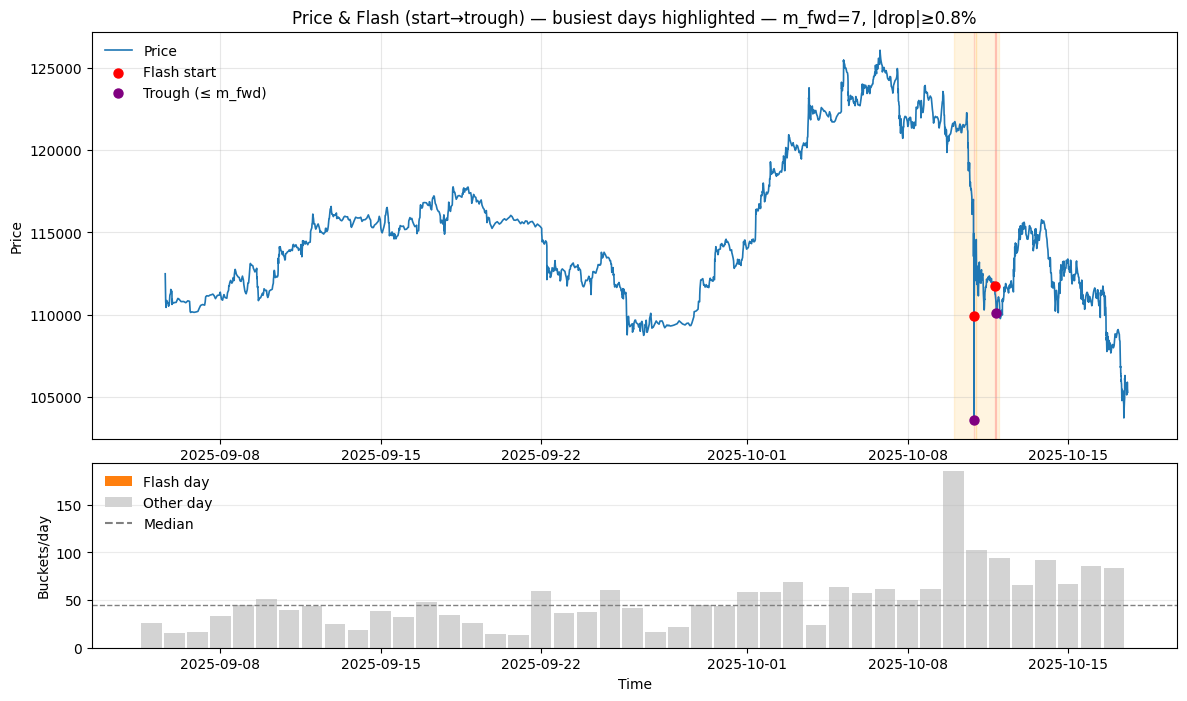

            buckets_per_day  window_hours_median  window_hours_min  window_hours_max
day                                                                                 
2025-09-05               26                  NaN               NaN               NaN
2025-09-06               15                  NaN               NaN               NaN
2025-09-07               17                51.06             45.32             56.99
2025-09-08               33                58.97             46.64             61.80
2025-09-09               45                30.84             26.67             46.28
2025-09-10               51                23.82             21.84             28.65
2025-09-11               40                24.98             22.23             30.86
2025-09-12               44                27.22             25.88             29.99
2025-09-13               25                32.40             25.97             36.86
2025-09-14               19                44.36             38.4

In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ===== INPUT =====
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

N = 50            # chỉ để tính "bucket clock"
m_fwd = 7         # số bucket nhìn tới để đo drawdown
min_abs_drop = -0.008  # ngưỡng rơi tối thiểu để coi là flash (0.8%)
tz = df.index.tz

# ===== Buckets/day & "bucket clock" =====
per_day = df.assign(day=lambda x: x.index.tz_convert(tz).date if tz else x.index.date) \
            .groupby('day').size().rename('buckets_per_day')

idx = df.index
earlier_idx = idx.to_series().shift(N-1)
df['vp_window_hours'] = (idx.to_series() - earlier_idx).dt.total_seconds()/3600.0

# ===== Drawdown tương lai (dd_m) & trough =====
def forward_drawdown(s_price: pd.Series, m: int):
    fut = pd.concat([s_price.shift(-k) for k in range(1, m+1)], axis=1)
    fwd_min = fut.min(axis=1)
    dd_m = (fwd_min / s_price) - 1
    return dd_m, fut

dd_m, fut_matrix = forward_drawdown(df['Price'], m_fwd)

# ===== CHỌN 2 NGÀY "BẬN" NHẤT rồi lấy 1 flash sâu nhất/ngày (giữ đúng panel trên như bạn đang dùng)
busy_days = per_day.sort_values(ascending=False).head(2).index  # kiểu date

starts, troughs = [], []
for d in busy_days:
    mask_day = (dd_m.index.tz_convert(tz).date == d) if tz else (dd_m.index.date == d)
    dd_day = dd_m[mask_day]
    if dd_day.empty:
        continue
    t_star = dd_day.idxmin()
    if np.isnan(dd_m.loc[t_star]) or dd_m.loc[t_star] > min_abs_drop:
        continue
    row = fut_matrix.loc[t_star].values
    j = int(np.nanargmin(row))  # 0..m_fwd-1
    trough_pos = df.index.get_loc(t_star) + (j+1)
    trough_pos = max(0, min(trough_pos, len(df.index)-1))
    t_trough = df.index[trough_pos]
    starts.append(t_star); troughs.append(t_trough)

starts = pd.DatetimeIndex(sorted(starts))
troughs = pd.DatetimeIndex([t for _, t in sorted(zip(starts, troughs))])
flash_days = { (t.tz_convert(tz).date if tz else t.date()) for t in starts }  # set ngày có flash

print(f"Số flash (1/ngày bận): {len(starts)} — days={list(map(str, busy_days))}")

# ===== VẼ =====
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2, 1, height_ratios=[2.2, 1], hspace=0.08)
ax_p = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[1, 0], sharex=ax_p)

# --- Panel trên: PRICE + flash ---
ax_p.plot(df.index, df['Price'], label='Price', linewidth=1.2)

# Tô nền 2 ngày bận
for d in busy_days:
    d0 = pd.Timestamp(d).tz_localize(tz) if tz else pd.Timestamp(d)
    d1 = d0 + pd.Timedelta(days=1)
    ax_p.axvspan(d0, d1, color='orange', alpha=0.12, zorder=0)

# Markers
if len(starts):
    ax_p.scatter(starts, df.loc[starts,'Price'], s=42, color='red', label='Flash start', zorder=3)
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs,'Price'], s=42, color='purple', label='Trough (≤ m_fwd)', zorder=3)
for st, tr in zip(starts, troughs):
    if pd.notna(tr) and tr >= st:
        ax_p.axvspan(st, tr, alpha=0.15, color='red')

ax_p.set_ylabel('Price')
ax_p.grid(alpha=.3)
ax_p.legend(loc='upper left', frameon=False)
ax_p.set_title(f"Price & Flash (start→trough) — busiest days highlighted — m_fwd={m_fwd}, |drop|≥{abs(min_abs_drop)*100:.1f}%")

# --- Panel dưới: SỐ BUCKET MỖI NGÀY (highlight ngày có flash) ---
# chuẩn hóa trục x theo daily ticks
all_days = pd.date_range(
    (df.index.min().tz_convert(tz).normalize() if tz else df.index.min().normalize()),
    (df.index.max().tz_convert(tz).normalize() if tz else df.index.max().normalize()),
    freq='D'
).date
per_day_full = per_day.reindex(all_days).fillna(0)

colors = ['tab:orange' if d in flash_days else 'lightgray' for d in per_day_full.index]
ax_b.bar(per_day_full.index, per_day_full.values, color=colors, width=0.9, align='center', edgecolor='none', label='Buckets/day')

# median line
med_bpd = per_day_full.replace(0, np.nan).median()
if not np.isnan(med_bpd):
    ax_b.axhline(med_bpd, ls='--', lw=1.0, color='gray', label=f'Median={med_bpd:.0f}')

# annotate riêng cho ngày có flash
for d in per_day_full.index:
    if d in flash_days:
        ax_b.text(d, per_day_full.loc[d] + 1, f"{int(per_day_full.loc[d])}", ha='center', va='bottom', fontsize=9, color='tab:orange')

ax_b.set_ylabel('Buckets/day')
ax_b.grid(alpha=.25, axis='y')
# chú thích màu
from matplotlib.patches import Patch
legend_patches = [
    Patch(facecolor='tab:orange', edgecolor='none', label='Flash day'),
    Patch(facecolor='lightgray', edgecolor='none', label='Other day'),
]
ax_b.legend(handles=legend_patches + ([plt.Line2D([0],[0], ls='--', color='gray', label='Median')] if not np.isnan(med_bpd) else []),
            frameon=False, loc='upper left')

plt.xlabel('Time')
plt.tight_layout()
plt.show()

# ===== BẢNG TÓM TẮT (nếu cần in) =====
summary = pd.DataFrame({
    'buckets_per_day': per_day,
}).assign(
    window_hours_median=lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).median(),
    window_hours_min   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).min(),
    window_hours_max   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).max(),
)
print(summary.round(2).to_string())


Số flash (1/ngày bận): 2 — days=['2025-10-10', '2025-10-11']


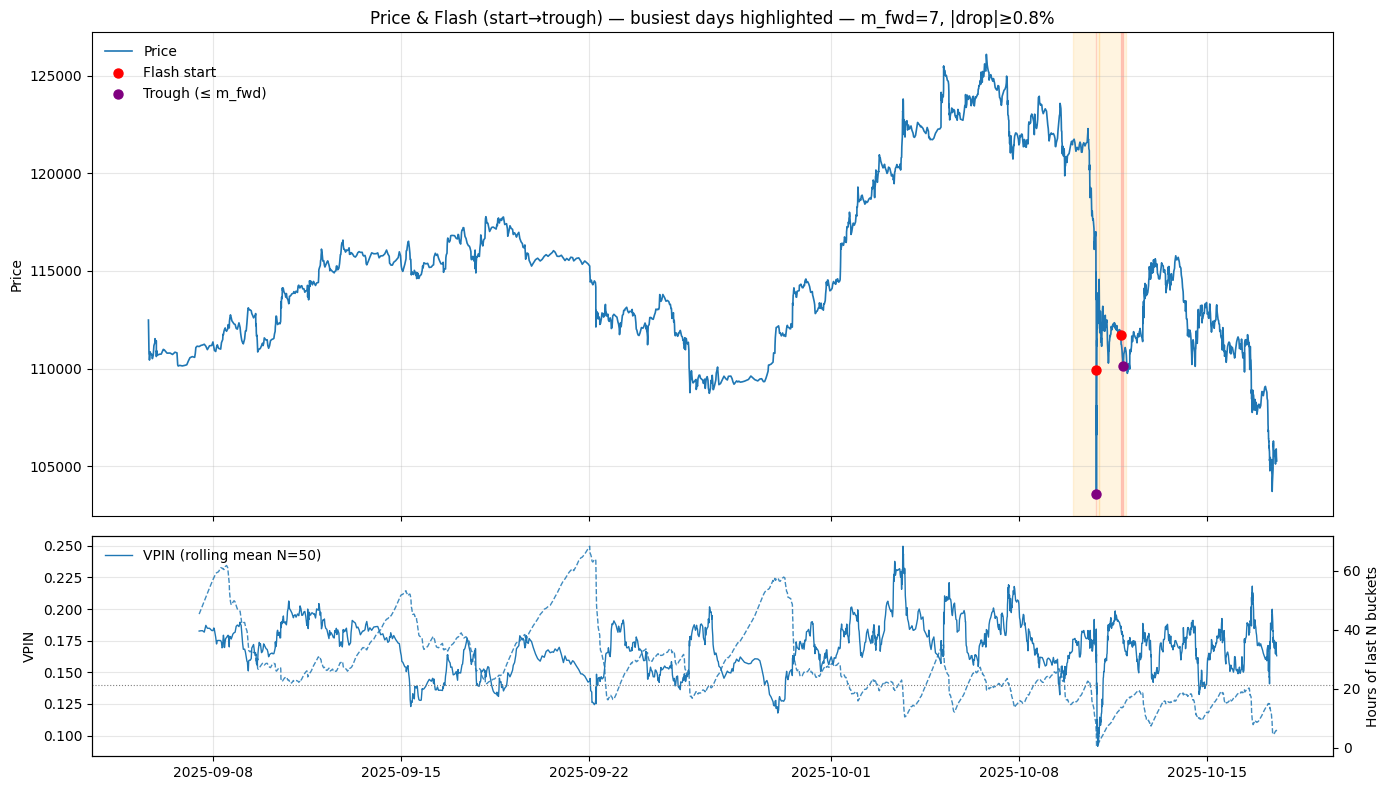

            buckets_per_day  window_hours_median  window_hours_min  window_hours_max
day                                                                                 
2025-09-05               26                  NaN               NaN               NaN
2025-09-06               15                  NaN               NaN               NaN
2025-09-07               17                51.06             45.32             56.99
2025-09-08               33                58.97             46.64             61.80
2025-09-09               45                30.84             26.67             46.28
2025-09-10               51                23.82             21.84             28.65
2025-09-11               40                24.98             22.23             30.86
2025-09-12               44                27.22             25.88             29.99
2025-09-13               25                32.40             25.97             36.86
2025-09-14               19                44.36             38.4

In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ===== INPUT =====
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

N = 50           # cửa sổ VPIN (tham chiếu lý thuyết)
m_fwd = 7        # số bucket nhìn tới để đo drawdown
min_abs_drop = -0.008  # ngưỡng rơi tối thiểu để “được tính” (vd 0.8%)
tz = df.index.tz  # timezone của dữ liệu (có thể là None nếu tz-naive)

# ===== Buckets/day & “bucket clock” (giờ phủ của N bucket) =====
per_day = df.assign(day=lambda x: x.index.tz_convert(tz).date if tz else x.index.date) \
            .groupby('day').size().rename('buckets_per_day')

idx = df.index
earlier_idx = idx.to_series().shift(N-1)
df['vp_window_hours'] = (idx.to_series() - earlier_idx).dt.total_seconds()/3600.0

# ===== 1) TÍNH DRAWNDOWN TƯƠNG LAI CHO TOÀN CHUỖI =====
def forward_drawdown(s_price: pd.Series, m: int):
    fut = pd.concat([s_price.shift(-k) for k in range(1, m+1)], axis=1)
    fwd_min = fut.min(axis=1)
    dd_m = (fwd_min / s_price) - 1
    return dd_m, fut

dd_m, fut_matrix = forward_drawdown(df['Price'], m_fwd)

# ===== 2) CHỌN 2 NGÀY “BẬN” NHẤT =====
busy_days = per_day.sort_values(ascending=False).head(2).index  # mảng kiểu date

# ===== 3) VỚI MỖI NGÀY BẬN: LẤY 1 FLASH SÂU NHẤT/NGÀY =====
starts, troughs = [], []
for d in busy_days:
    # mask theo ngày KHỚP TZ
    day_mask = (dd_m.index.tz_convert(tz).date == d) if tz else (dd_m.index.date == d)
    dd_day = dd_m[day_mask]
    if dd_day.empty:
        continue

    t_star = dd_day.idxmin()
    if np.isnan(dd_m.loc[t_star]) or dd_m.loc[t_star] > min_abs_drop:
        continue

    # trough trong m_fwd bucket sau t_star
    row = fut_matrix.loc[t_star].values
    j = int(np.nanargmin(row))  # 0..m_fwd-1
    trough_pos = df.index.get_loc(t_star) + (j+1)
    trough_pos = max(0, min(trough_pos, len(df.index)-1))
    t_trough = df.index[trough_pos]

    starts.append(t_star)
    troughs.append(t_trough)

starts = pd.DatetimeIndex(sorted(starts))
troughs = pd.DatetimeIndex([t for _, t in sorted(zip(starts, troughs))])

print(f"Số flash (1/ngày bận): {len(starts)} — days={list(map(str, busy_days))}")

# ===== 4) VẼ =====
fig, (ax_p, ax_v) = plt.subplots(2,1,figsize=(14,8),sharex=True,gridspec_kw={'height_ratios':[2.2,1]})

# Price
ax_p.plot(df.index, df['Price'], label='Price', linewidth=1.2)

# Tô nền các ngày bận (khớp tz)
for d in busy_days:
    day_start = pd.Timestamp(d).tz_localize(tz) if tz else pd.Timestamp(d)
    day_end   = day_start + pd.Timedelta(days=1)
    ax_p.axvspan(day_start, day_end, color='orange', alpha=0.12, zorder=0)

# Markers start (đỏ) & trough (tím) + dải rơi
if len(starts):
    ax_p.scatter(starts, df.loc[starts,'Price'], s=42, color='red', label='Flash start', zorder=3)
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs,'Price'], s=42, color='purple', label='Trough (≤ m_fwd)', zorder=3)
for st, tr in zip(starts, troughs):
    if pd.notna(tr) and tr >= st:
        ax_p.axvspan(st, tr, alpha=0.15, color='red')

ax_p.set_ylabel('Price'); ax_p.grid(alpha=.3)
ax_p.legend(loc='upper left', frameon=False)
ax_p.set_title(f"Price & Flash (start→trough) — busiest days highlighted — m_fwd={m_fwd}, |drop|≥{abs(min_abs_drop)*100:.1f}%")

# VPIN + “bucket clock”
if 'VPIN' in df.columns:
    ax_v.plot(df.index, df['VPIN'], label=f'VPIN (rolling mean N={N})', linewidth=1.0)
    ax_v.legend(loc='upper left', frameon=False)
ax_v.set_ylabel('VPIN'); ax_v.grid(alpha=.3)

ax2 = ax_v.twinx()
ax2.plot(df.index, df['vp_window_hours'], '--', linewidth=1.0, alpha=.85, label='Window length (hours)')
ax2.axhline(np.nanmedian(df['vp_window_hours']), color='gray', linestyle=':', linewidth=0.8)
ax2.set_ylabel('Hours of last N buckets')

plt.xlabel('Time'); plt.tight_layout(); plt.show()

# ===== 5) BẢNG TÓM TẮT =====
summary = pd.DataFrame({
    'buckets_per_day': per_day,
}).assign(
    window_hours_median=lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).median(),
    window_hours_min   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).min(),
    window_hours_max   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).max(),
)
print(summary.round(2).to_string())


VPIN-spike lead hit-rate (Z=1.5, lookback=10b): 50.00% — 1/2 events


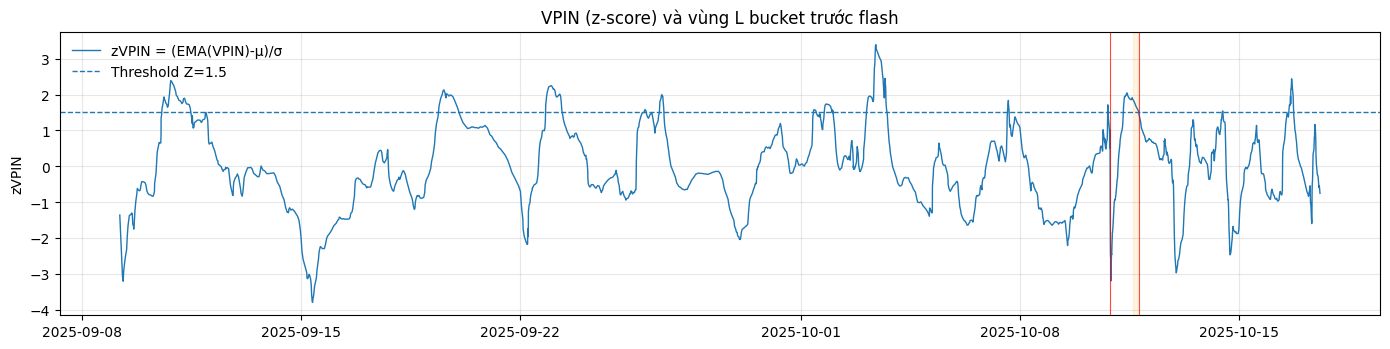

In [11]:
# === zVPIN & kiểm tra lead trước flash ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Z = 1.5          # ngưỡng z-score
L = 10           # nhìn lùi L bucket trước flash
ema_span = 8
z_win = 150

v = df['VPIN'].astype(float)
ema = v.ewm(span=ema_span, adjust=False).mean()
mu  = ema.rolling(z_win, min_periods=max(30, z_win//3)).mean()
sd  = ema.rolling(z_win, min_periods=max(30, z_win//3)).std()
zv  = (ema - mu) / sd
spike = (zv >= Z)

# Tính tỉ lệ flash có spike trong L bucket trước sự kiện
hits = []
for t in starts:
    pos = df.index.get_loc(t)
    pre = spike.iloc[max(0, pos-L):pos]
    hits.append(bool(pre.any()))
hit_rate = np.mean(hits) if len(hits) else np.nan
print(f"VPIN-spike lead hit-rate (Z={Z}, lookback={L}b): {hit_rate:.2%} — {np.sum(hits)}/{len(hits)} events")

# Vẽ panel VPIN với z-threshold & tô vùng trước flash
fig, ax = plt.subplots(1,1,figsize=(14,3.6), sharex=True)
ax.plot(df.index, zv, lw=1.0, label='zVPIN = (EMA(VPIN)-μ)/σ')
ax.axhline(Z, ls='--', lw=1.0, label=f'Threshold Z={Z}')
for t in starts:
    pos = df.index.get_loc(t)
    a = df.index[max(0, pos-L)]
    b = df.index[pos-1] if pos>0 else df.index[0]
    if b>=a: ax.axvspan(a, b, color='orange', alpha=0.12)
    ax.axvline(t, color='red', lw=0.8, alpha=0.7)
ax.set_ylabel('zVPIN'); ax.grid(alpha=.3); ax.legend(frameon=False, loc='upper left')
ax.set_title('VPIN (z-score) và vùng L bucket trước flash')
plt.tight_layout(); plt.show()


In [12]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ===================== INPUT =====================
# df có: Time, Price, VPIN (đúng sách; không cần resample)
df = df.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

# ===================== THAM SỐ LÝ THUYẾT =====================
N = 50  # độ dài mẫu theo lý thuyết (50 buckets)

# ===================== (A) HÀM PHÁT HIỆN FLASH TỪ GIÁ =====================
def detect_flash_price_only(s, m_fwd=7, tail_q=0.03, vol_win=100, min_abs_drop=-0.008, cool_off=10):
    """
    Phát hiện flash từ GIÁ (không resample):
      - Với mỗi t: xét P[t+1..t+m_fwd], lấy min -> drawdown tương lai: min/P[t] - 1 (âm khi rơi)
      - 'Flash' nếu drawdown <= ngưỡng đuôi (tail_q) của pct_change(m_fwd) ROLLING (không nhìn tương lai)
        VÀ drawdown <= min_abs_drop (ví dụ ≤ -0.8%)
      - Gộp cụm các điểm cách nhau <= cool_off bucket, giữ điểm có drawdown nhỏ nhất (rơi mạnh nhất)
    Trả về: start_times (DatetimeIndex), dd_m (Series), tail_thr (Series), trough_times (DatetimeIndex)
    """
    s = s[['Price']].copy()
    # Matrix giá tương lai P[t+1..t+m]
    future_prices = pd.concat([s['Price'].shift(-k) for k in range(1, m_fwd+1)], axis=1)
    future_prices.columns = [f'+{k}' for k in range(1, m_fwd+1)]
    fwd_min = future_prices.min(axis=1)
    dd_m = (fwd_min / s['Price']) - 1  # âm khi rơi

    # Ngưỡng đuôi dựa trên pct_change(m_fwd) quá khứ (rolling)
    hist_cum = s['Price'].pct_change(m_fwd)
    tail_thr = hist_cum.rolling(vol_win, min_periods=max(30, int(0.6*vol_win))).quantile(tail_q)
    thr = np.minimum(tail_thr, min_abs_drop)  # phải <= cả 2
    flash_raw = (dd_m <= thr) & thr.notna()

    # Gộp cụm theo cool_off
    idx_raw = np.flatnonzero(flash_raw.values)
    start_times = []
    k = 0
    while k < len(idx_raw):
        start = idx_raw[k]; end = start
        while k+1 < len(idx_raw) and (idx_raw[k+1] - idx_raw[k]) <= cool_off:
            k += 1; end = idx_raw[k]
        # chọn điểm rơi mạnh nhất trong cụm
        pick_time = dd_m.iloc[start:end+1].idxmin()
        start_times.append(pick_time)
        k += 1
    start_times = pd.DatetimeIndex(start_times)

    # Tìm đáy (trough) trong m_fwd bucket sau mỗi start
    trough_times = []
    if len(start_times):
        pos = s.index.get_indexer(start_times)
        for p in pos:
            row = future_prices.iloc[p].values  # giá +1..+m
            j = int(np.argmin(row))            # 0..m-1
            trough_idx = p + (j + 1)
            trough_idx = max(0, min(trough_idx, len(s.index)-1))
            trough_times.append(s.index[trough_idx])
    trough_times = pd.DatetimeIndex(trough_times)

    return start_times, dd_m, tail_thr, trough_times

# ===================== (B) SỐ BUCKET MỖI NGÀY =====================
per_day = df.assign(day=lambda x: x.index.date).groupby('day').size().rename('buckets_per_day')

# ===================== (C) THỜI LƯỢNG HIỆU DỤNG CỦA CỬA SỔ N BUCKET (giờ) =====================
idx = df.index
earlier_idx = idx.to_series().shift(N-1)
effective_hours = (idx.to_series() - earlier_idx).dt.total_seconds() / 3600.0
df['vp_window_hours'] = effective_hours.values  # NaN cho giai đoạn đầu < N

# ===================== (D) PHÁT HIỆN FLASH (PARAM GỢI Ý) =====================
# Bạn có thể chỉnh các tham số này để nhạy hơn/ít hơn:
price_params = dict(m_fwd=7, tail_q=0.03, vol_win=2*N, min_abs_drop=-0.008, cool_off=10)
starts, dd_m, tail_thr, troughs = detect_flash_price_only(df, **price_params)

print(f"Số flash (price-only): {len(starts)}")
if len(starts):
    print(f"Từ {starts.min()} đến {starts.max()}")

# ===================== (E) VẼ: GIÁ + FLASH (đỏ: start, tím: trough) & VPIN + giờ cửa sổ =====================
fig, (ax_p, ax_v) = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                                 gridspec_kw={'height_ratios':[2.2,1]})

# --- Giá ---
ax_p.plot(df.index, df['Price'], label='Price', linewidth=1.2)
# đánh dấu start & trough
if len(starts):
    ax_p.scatter(starts, df.loc[starts, 'Price'], s=36, color='red', zorder=3, label='Flash start')
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs, 'Price'], s=36, color='purple', zorder=3, label='Trough (≤ m_fwd)')

# tô dải từ start → trough
for i, st in enumerate(starts):
    if len(troughs) > i:
        tr = troughs[i]
        if pd.notna(tr) and tr >= st:
            ax_p.axvspan(st, tr, alpha=0.12, color='red')

ax_p.set_ylabel('Price')
ax_p.grid(alpha=.3)
ax_p.legend(frameon=False, loc='upper left')
ax_p.set_title(f"Price & Flash (start→trough) — params={price_params}")

# --- VPIN + trục phụ là giờ cửa sổ N bucket ---
if 'VPIN' in df.columns:
    ax_v.plot(df.index, df['VPIN'], label=f'VPIN (rolling mean N={N})', linewidth=1.1)
    ax_v.set_ylabel('VPIN')
    ax_v.legend(frameon=False, loc='upper left')
ax_v.grid(alpha=.3)

ax2 = ax_v.twinx()
ax2.plot(df.index, df['vp_window_hours'], linestyle='--', linewidth=1.0, alpha=.85, label='Window length (hours)')
ax2.set_ylabel('Hours of last N buckets')
med_hours = np.nanmedian(df['vp_window_hours'])
ax2.axhline(med_hours, color='gray', linestyle=':', linewidth=0.8)

plt.xlabel('Time')
plt.tight_layout()
plt.show()

# ===================== (F) BẢNG TÓM TẮT =====================
summary = pd.DataFrame({
    'buckets_per_day': per_day,
}).assign(
    window_hours_median=lambda s: df['vp_window_hours'].groupby(df.index.date).median(),
    window_hours_min   =lambda s: df['vp_window_hours'].groupby(df.index.date).min(),
    window_hours_max   =lambda s: df['vp_window_hours'].groupby(df.index.date).max(),
)
print(summary.round(2).to_string())


KeyError: 'Time'

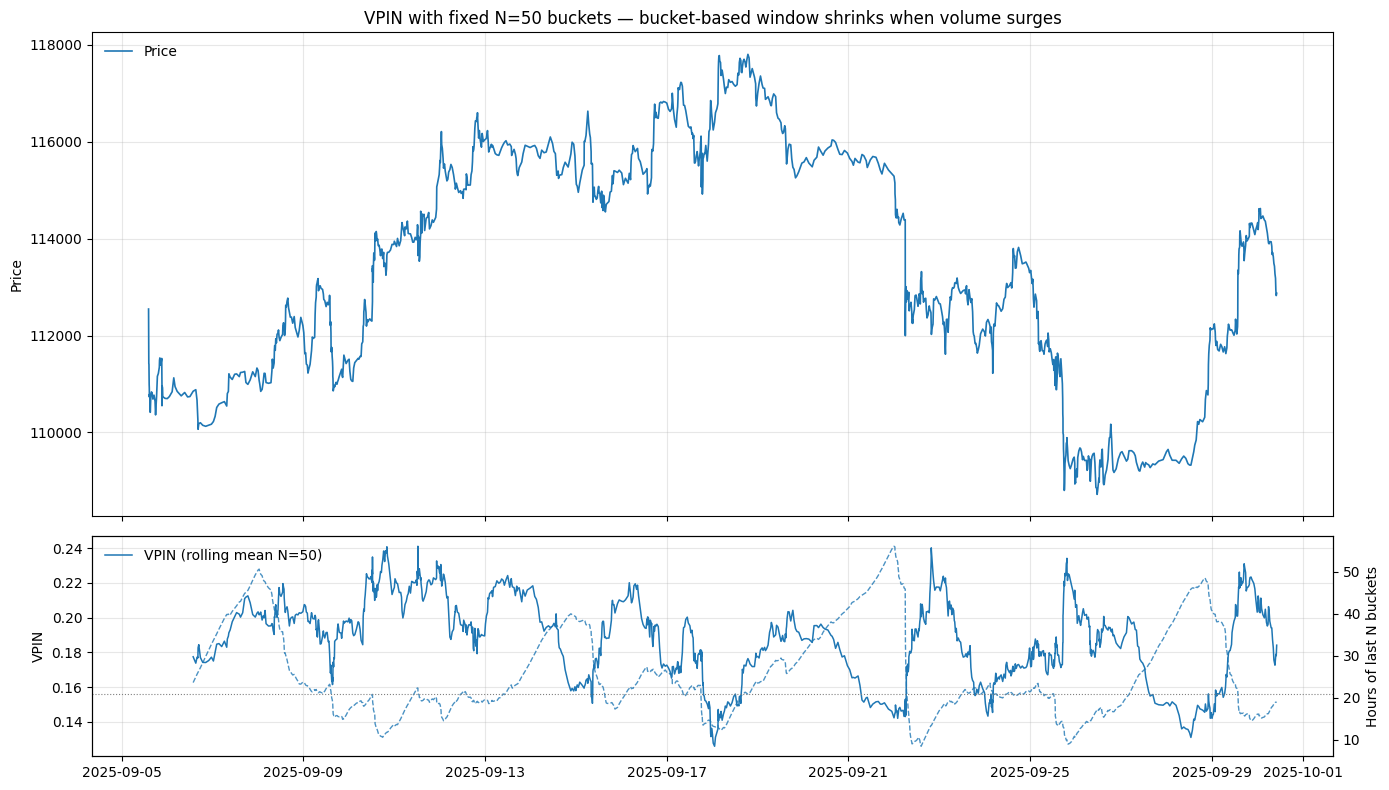

            buckets_per_day  window_hours_median  window_hours_min  window_hours_max
day                                                                                 
2025-09-05               39                  NaN               NaN               NaN
2025-09-06               22                26.12             23.56             32.67
2025-09-07               24                40.88             33.61             49.88
2025-09-08               50                35.94             23.19             50.60
2025-09-09               66                21.35             14.80             23.58
2025-09-10               75                17.80             10.53             20.74
2025-09-11               59                19.48             13.30             22.26
2025-09-12               66                18.92             14.47             21.43
2025-09-13               36                20.98             18.56             28.36
2025-09-14               29                37.01             29.6

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ==== INPUT ====
# df có: Time, Price, Buy, Sell, Volume, VPIN (đúng sách, rolling mean theo N bucket, hoặc tự tính lại)
df = df.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

# ==== THAM SỐ LÝ THUYẾT ====
N = 50  # độ dài mẫu theo lý thuyết (50 buckets)

# ==== (1) ĐẾM SỐ BUCKET MỖI NGÀY (buckets/day) ====
per_day = df.assign(day=lambda x: x.index.date).groupby('day').size().rename('buckets_per_day')

# ==== (2) THỜI LƯỢNG HIỆU DỤNG CỦA CỬA SỔ N BUCKET (giờ) ====
# với mỗi thời điểm t, lấy chênh lệch thời gian giữa t và t-(N-1) bucket
idx = df.index
earlier_idx = df.index.to_series().shift(N-1)
effective_hours = (idx.to_series() - earlier_idx).dt.total_seconds() / 3600.0
df['vp_window_hours'] = effective_hours.values  # NaN cho giai đoạn đầu < N

# ==== (3) VẼ: Giá & VPIN + trục phụ hiển thị giờ của cửa sổ VPIN ====
fig, (ax_p, ax_v) = plt.subplots(2,1,figsize=(14,8), sharex=True, gridspec_kw={'height_ratios':[2.2,1]})

# Giá
ax_p.plot(df.index, df['Price'], label='Price', linewidth=1.2)
ax_p.set_ylabel('Price'); ax_p.grid(alpha=.3); ax_p.legend(frameon=False, loc='upper left')
ax_p.set_title(f'VPIN with fixed N={N} buckets — bucket-based window shrinks when volume surges')

# VPIN + trục phụ là giờ cửa sổ
vpin_series = df['VPIN'] if 'VPIN' in df.columns else None  # hoặc df['VPIN_th']
if vpin_series is not None:
    ax_v.plot(df.index, vpin_series, label=f'VPIN (rolling mean N={N})', linewidth=1.1)
    ax_v.set_ylabel('VPIN'); ax_v.grid(alpha=.3); ax_v.legend(frameon=False, loc='upper left')

ax2 = ax_v.twinx()
ax2.plot(df.index, df['vp_window_hours'], linestyle='--', linewidth=1.0, alpha=.8, label='Window length (hours)')
ax2.set_ylabel('Hours of last N buckets')

# chú thích gọn: median của giờ cửa sổ
med_hours = np.nanmedian(df['vp_window_hours'])
ax2.axhline(med_hours, color='gray', linestyle=':', linewidth=0.8)

plt.xlabel('Time'); plt.tight_layout(); plt.show()

# ==== (4) BẢNG TÓM TẮT ====
summary = pd.DataFrame({
    'buckets_per_day': per_day,
}).assign(
    window_hours_median=lambda s: df['vp_window_hours'].groupby(df.index.date).median(),
    window_hours_min=lambda s: df['vp_window_hours'].groupby(df.index.date).min(),
    window_hours_max=lambda s: df['vp_window_hours'].groupby(df.index.date).max(),
)
print(summary.round(2).to_string())


In [ ]:
# ================= RE-RUN with a looser grid & F-beta (β=0.5) =================
from math import sqrt

def score_fb(prec, rec, beta=0.5):
    if prec==0 and rec==0: return 0.0
    b2 = beta**2
    return (1+b2)*prec*rec/(b2*prec+rec) if (b2*prec+rec)>0 else 0.0

# ---- Grid mở hơn ----
BPD = 50
price_grid = [
    dict(m_fwd=m, tail_q=tq, vol_win=2*BPD, min_abs_drop=mad, cool_off=8)
    for m in (5,7)                      # m rộng thêm
    for tq in (0.02, 0.03)              # p2%–p3% (nới)
    for mad in (-0.008, -0.01)          # rơi tối thiểu 0.8%–1.0% (nới nhẹ)
]

vpin_grid = [
    dict(vpin_q=vq, vpin_q_win=5*BPD, lookback_L=L,
         consec_C=C, slope_min=sl, hours_max=H, N_for_hours=50, alert_cooloff=6)
    for vq in (0.98, 0.99)              # hạ ngưỡng sang p98
    for L  in (10, 12)                  # lookback ngắn hơn
    for C  in (5, 7, 8)                 # yêu cầu liên tiếp thấp hơn
    for sl in (-0.0005, 0.0)            # cho phép dốc ≈ phẳng / hơi âm
    for H  in (None, 20)                # có thể bỏ gate theo hours
]

# ---- Sweep với các ràng buộc tối thiểu để tránh cấu hình vô nghĩa ----
rows=[]
for p in price_grid:
    start_tr, _, _, _ = detect_flash_price_only(train, **p)
    n_ev_tr = len(start_tr)
    for v in vpin_grid:
        met = evaluate_lead(train, p, v, horizon=p['m_fwd'])
        # lọc cấu hình phải có alert đủ lớn để học
        if met['n_alerts'] >= max(5, n_ev_tr) and met['n_alerts'] <= 0.7*len(train):
            met['fbeta05'] = score_fb(met['precision'], met['recall'], beta=0.5)
            rows.append({**{'price':p,'vpin':v,'n_events_train':n_ev_tr}, **met})

res = pd.DataFrame(rows)
if res.empty:
    print("⚠️ Grid vẫn quá chặt, không cấu hình nào qua được ràng buộc tối thiểu.\n"
          "Gợi ý: tăng tail_q lên 0.04, giảm consec_C xuống 4, cho hours_max=None.")
else:
    res = res.sort_values(['fbeta05','precision','recall'], ascending=False)
    print("TOP cấu hình (TRAIN, F-beta=0.5):\n",
          res[['price','vpin','n_events_train','n_events','n_alerts','tp','fp','fn',
               'precision','recall','fbeta05']].head(10).to_string(index=False))

    best_price = res.iloc[0]['price']
    best_vpin  = res.iloc[0]['vpin']

    # ---- Đánh giá trên TEST ----
    metrics_test = evaluate_lead(test, best_price, best_vpin, horizon=best_price['m_fwd'])
    print("\nHiệu năng TEST:", metrics_test)

    # ---- Vẽ & Xuất CSV như thường lệ ----
    start_all, dd_m_all, tail_thr_all, trough_all = detect_flash_price_only(df, **best_price)
    lead_mask_all, vpin_thr_all = vpin_lead_mask_strict(df, **best_vpin)
    plot_vpin_flash(df, start_all, trough_all, vpin_thr=vpin_thr_all,
                    lookback=max(10, int(0.3*best_vpin['lookback_L'])),
                    title=f"VPIN & Flash — price={best_price}, vpin={best_vpin}")

    events_table = enrich_events(df, start_all, trough_all, dd_m_all, lookback=best_vpin['lookback_L'])
    events_table['vpin_lead_flag'] = lead_mask_all.reindex(events_table.index, method='ffill').astype(bool)
    events_table.to_csv('flash_events_with_vpin.csv', index=True)
    print("\nĐã lưu: flash_events_with_vpin.csv")
    print(events_table.head().to_string(float_format=lambda x: f"{x:.6f}"))


⚠️ Grid vẫn quá chặt, không cấu hình nào qua được ràng buộc tối thiểu.
Gợi ý: tăng tail_q lên 0.04, giảm consec_C xuống 4, cho hours_max=None.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================== THAM SỐ ==================
DROP_PCT   = 0.02          # giảm tối thiểu trong cửa sổ (2%)
TIME_WINDOW = '15min'      # độ dài cửa sổ xét "tương lai" (vd '5min','15min','30min')
COOLDOWN    = '10min'      # thời gian nghỉ giữa 2 sự kiện (tránh trùng)
ANNOTATE_TOP_DAYS = True
# =============================================

# Bản sao an toàn
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)

times  = df['Time'].values
prices = df['Price'].values
n = len(df)

# Hàm nhảy index theo cooldown thời gian
def advance_to_time(idx, target_time):
    # trả về chỉ số >= target_time
    j = np.searchsorted(times, np.datetime64(target_time), side='left')
    return max(j, idx+1)

# Phát hiện flash crash theo TIME_WINDOW
events = []
i = 0
while i < n:
    end_time = pd.Timestamp(times[i]) + pd.Timedelta(TIME_WINDOW)
    j_end = np.searchsorted(times, np.datetime64(end_time), side='right')
    if j_end <= i + 1:
        i += 1
        continue
    # tìm đáy trong [i, j_end)
    seg = prices[i:j_end]
    trough_off = np.argmin(seg)
    trough_i = i + trough_off
    drop = (prices[trough_i] - prices[i]) / prices[i]
    if drop <= -DROP_PCT:
        events.append({
            'start_idx': i,
            'trough_idx': trough_i,
            'start_time': pd.Timestamp(times[i]),
            'trough_time': pd.Timestamp(times[trough_i]),
            'start_price': prices[i],
            'trough_price': prices[trough_i],
            'drop_pct': drop
        })
        # nhảy qua cooldown kể từ trough
        i = advance_to_time(trough_i, pd.Timestamp(times[trough_i]) + pd.Timedelta(COOLDOWN))
    else:
        i += 1

ev_df = pd.DataFrame(events)

# ==== Đếm theo ngày (để panel dưới vẫn trực quan tổng hợp) ====
if not ev_df.empty:
    day_counts = (ev_df.groupby(ev_df['start_time'].dt.date)
                  .size().rename('count').reset_index().rename(columns={'start_time':'date'}))
else:
    day_counts = pd.DataFrame(columns=['date','count'])
all_days = pd.DataFrame({'date': pd.to_datetime(df['Time'].dt.date.unique())})
day_counts = all_days.merge(day_counts, on='date', how='left').fillna({'count':0})
median_cnt = int(day_counts['count'].median()) if len(day_counts) else 0

# ================== VẼ HÌNH ==================
plt.rcParams.update({'axes.grid': False})
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[2.5, 1.0], hspace=0.35)

# Panel 1 — Giá + sự kiện trong KHOẢNH KHẮC ngắn (start→trough)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df['Time'], df['Price'], label='Giá', linewidth=1.4)

if not ev_df.empty:
    for _, r in ev_df.iterrows():
        ax1.axvspan(r['start_time'], r['trough_time'], alpha=0.15, color='red')
        ax1.scatter(r['start_time'], r['start_price'], color='red', s=35, zorder=3, label='_nolegend_')
        ax1.scatter(r['trough_time'], r['trough_price'], color='purple', s=35, zorder=3, label='_nolegend_')

ax1.set_title(f"Giá và các đợt 'flash crash' (giảm ≥ {DROP_PCT*100:.1f}% trong {TIME_WINDOW})",
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Giá')
ax1.legend(loc='upper left')

# Panel 2 — Số sự kiện theo ngày (tổng hợp, nhưng phát hiện là intraday)
ax2 = fig.add_subplot(gs[1, 0])
dates = pd.to_datetime(day_counts['date'])
counts = day_counts['count'].values
has_event = counts > 0

ax2.bar(dates[~has_event], counts[~has_event], width=0.9, alpha=0.5, label='Ngày khác')
ax2.bar(dates[has_event], counts[has_event], width=0.9, label='Ngày có sụp đổ chớp nhoáng')
ax2.axhline(median_cnt, linestyle='--', linewidth=1, label=f'Trung vị = {median_cnt}')

if ANNOTATE_TOP_DAYS and len(day_counts):
    for x, y in zip(dates[has_event], counts[has_event]):
        if y > 0:
            ax2.text(x, y + 0.05, f'{y}', ha='center', va='bottom', fontsize=8)

ax2.set_ylabel('Số nhóm / ngày')
ax2.set_xlabel('Thời gian')
ax2.legend(loc='upper left')
fig.autofmt_xdate(rotation=30)
plt.tight_layout()
plt.show()


ValueError: You are trying to merge on datetime64[ns] and object columns for key 'date'. If you wish to proceed you should use pd.concat